## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from matplotlib.lines import Line2D
import seaborn as sns
import kds
import shap
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from skopt import BayesSearchCV
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder,OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer,LabelEncoder
from sklearn.metrics import accuracy_score
from scikitplot.metrics import  plot_confusion_matrix
from xgboost import XGBClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv('data.csv')

## Pipelines


In [3]:
# se crea la variable "is_cancer" según el diagnostico
df["is_cancer"] = df["diagnostic"].apply(lambda x: 1 if x in ["BCC","MEL","SCC"] else 0)

In [4]:
df.columns

Index(['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father',
       'background_mother', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed', 'is_cancer'],
      dtype='object')

In [5]:
# ¿Una persona tiene más de una lesión cutánea? ¿En el mismo lugar? 

x = df.drop(columns=["is_cancer", "diagnostic"]) 
y1 = df["is_cancer"]
y2 = df["diagnostic"]
y_cancer = df["is_cancer"]

class HadBeforeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x:pd.DataFrame, y):
        self.patient_counts = x["patient_id"].value_counts()
        #x["had_here_before"] = x["patient_id"].apply(lambda x: self.patient_counts[x] -1  )
        return self
    def transform(self, x:pd.DataFrame):
        new_counts = x["patient_id"].value_counts()
        if new_counts.equals( self.patient_counts):
            new_counts = {}

        x["had_here_before"] = x["patient_id"].apply(lambda x: self.patient_counts.get(x,0)+ new_counts.get(x,0) -1   )
        return x
    
class HadThisPartBeforeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x:pd.DataFrame, _):
        self.patient_region_counts = x.groupby(["patient_id", "region"]).size().unstack(fill_value=0).T.to_dict('dict')
        return self
    def transform(self, x:pd.DataFrame):
        new_counts = x.groupby(["patient_id", "region"]).size().unstack(fill_value=0).T.to_dict('dict')
        if new_counts == self.patient_region_counts:
            new_counts = {}
        x["had_this_part_before"] = x.apply(lambda row: 1 if  new_counts.get(row["patient_id"],{}).get(row["region"],0) + self.patient_region_counts.get(row["patient_id"],{}).get(row["region"],0)>=2 else 0, axis=1)
        return x

class NormalDistributionImputer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we will store the mean and std of the variables for prediction time
        self.param_dict_ = {}
        for var in self.variables:
            self.param_dict_[var] = {'mean': X[var].mean(), 'std': X[var].std()}
        return self

    def transform(self, X):
        #TODO: Agregar seed para random
        X = X.copy()
        for feature in self.variables:
            mu, std = self.param_dict_[feature]['mean'], self.param_dict_[feature]['std']
            X[feature] = X[feature].apply(lambda x: np.random.normal(loc=mu, scale=std) if pd.isnull(x) else x)
        return X

class ClassifierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classifier_class, new_column_name,
                  target_column=False, eta=0.3,max_depth=6 ,
                   scale_pos_weight=1,min_child_weight=1,gamma =0,
                   subsample=1,colsample_bytree=1,n_estimators=100):
        self.classifier_class = classifier_class
        self.eta = eta
        self.max_depth = max_depth
        self.scale_pos_weight = scale_pos_weight
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.n_estimators = n_estimators
        self.gamma = gamma
        self.classifier_kwargs = {"eta":eta, "max_depth":max_depth,"scale_pos_weight":scale_pos_weight}
        self.new_column_name = new_column_name
        self.target_column = target_column

        self.label_encoder = LabelEncoder()

    def fit(self, x, y):
        self.classifier = self.classifier_class(eta=self.eta, max_depth=self.max_depth,
        scale_pos_weight=self.scale_pos_weight,min_child_weight = self.min_child_weight,
        gamma = self.gamma,subsample=self.subsample,colsample_bytree=self.colsample_bytree,n_estimators=self.n_estimators )

        if self.target_column:
            y = y.apply(lambda x: 1 if x in ["BCC","MEL","SCC"] else 0)
        else:
            y = self.label_encoder.fit_transform(y)

        # Ensure x and y have the same length
        if len(x) != len(y):
            raise ValueError(f'Length of x ({len(x)}) does not match length of y ({len(y)})')

        self.classifier.fit(x, y)
        return self

    def transform(self, x):
        if not hasattr(self, 'classifier'):
            raise RuntimeError('You must call fit before calling transform')

        x_copy = x.copy()
        x_copy[self.new_column_name] = self.classifier.predict(x)
        return x_copy

    def predict(self, x):
        return self.label_encoder.inverse_transform(self.classifier.predict(x))
    
pipe = imbPipeline([
    ( "had_here_before", HadBeforeTransformer()),
    ( "had_this_part_before", HadThisPartBeforeTransformer()),
    ("dropear", FunctionTransformer(lambda x: x.drop(["img_id","lesion_id", "patient_id"], axis=1,))),
    ("frequency", CountFrequencyEncoder(encoding_method='frequency',variables=["region"])),
    ("missingIndicator",  AddMissingIndicator(variables=["smoke","drink","background_father",
                                        "background_mother","pesticide","gender","skin_cancer_history",
                                            "cancer_history", "has_piped_water","has_sewage_system",
                                            "itch","grew","hurt","changed","bleed","elevation","fitspatrick","diameter_1","diameter_2","age"])),
    ("fillNaNs", CategoricalImputer(imputation_method="missing", variables=["smoke","drink","background_father",
                                        "background_mother","pesticide","gender","skin_cancer_history",
                                            "cancer_history", "has_piped_water","has_sewage_system",
                                            "itch","grew","hurt","changed","bleed","elevation"])),
    ("ordinal", OrdinalEncoder(encoding_method="arbitrary", variables=["smoke","drink","background_father",
                                        "background_mother","pesticide","gender","skin_cancer_history",
                                            "cancer_history", "has_piped_water","has_sewage_system",
                                            "itch","grew","hurt","changed","bleed","elevation"])),
    ("imputar_numericas",NormalDistributionImputer(  variables= ["fitspatrick","diameter_1","diameter_2","age"])),
    ("clf",ClassifierTransformer(XGBClassifier, "is_cancer", target_column=True, scale_pos_weight=float(np.sum(y1 == 0))*100 / np.sum(y1 == 1))),
    ("smote",SMOTE()),
    ("clf2",ClassifierTransformer(XGBClassifier, "diagnostic",target_column=False))

])

In [6]:
# partición de datos en train y test
x1,x1_test,y1,y1_test = train_test_split(x,y2, test_size=0.2, random_state=42)
_,_,y_cancer,y_cancer_test = train_test_split(x,y_cancer, test_size=0.2, random_state=42)

In [7]:
pipe.set_params(**{'clf__eta': 0.01,
    'clf__max_depth': 10,
    'clf__min_child_weight': 2,
    'clf__gamma': 0,
    "clf__subsample": 1,
    "clf__colsample_bytree": 1,
    "clf__n_estimators": 361,


    'clf2__eta': 0.3,
    'clf2__max_depth': 13,
    'clf2__min_child_weight': 0,
    'clf2__gamma': 0,
    "clf2__subsample":1 ,
    "clf2__colsample_bytree": 1,
    "clf2__n_estimators": 1000,})
pipe.fit(x1,y1 )

[20:24:06] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



Pipeline(steps=[('had_here_before', HadBeforeTransformer()),
                ('had_this_part_before', HadThisPartBeforeTransformer()),
                ('dropear',
                 FunctionTransformer(func=<function <lambda> at 0x784e9869ca60>)),
                ('frequency',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['region'])),
                ('missingIndicator',
                 AddMissingIndicator(variables=['smoke', 'drink',
                                                'backgrou...
                 ClassifierTransformer(classifier_class=<class 'xgboost.sklearn.XGBClassifier'>,
                                       eta=0.01, max_depth=10,
                                       min_child_weight=2, n_estimators=361,
                                       new_column_name='is_cancer',
                                       scale_pos_weight=111.01928374655647,
                                       target_column=True)),
                ('smote', SMOTE()),
                ('clf2',
                 ClassifierTransformer(classifier_class=<class 'xgboost.sklearn.XGBClassifier'>,
                                       max_depth=13, min_child_weight=0,
                                       n_estimators=1000,
                                       new_column_name='diagnostic'))])

## Modelos

In [8]:
# optimización Bayesiana

param_space = {
    'clf__eta': (0.01, 0.3, 'uniform'),
    'clf__max_depth': (1, 10, 'uniform'),
    'clf__min_child_weight': (0,2,"uniform"),
    'clf__gamma': (0,2,"uniform"),
    "clf__subsample": (0.5,1,"uniform"),
    "clf__colsample_bytree": (0.5,1,"uniform"),
    "clf__n_estimators": (10,1000,"uniform"),


    'clf2__eta': (0.001, 0.5, 'uniform'),
    'clf2__max_depth': (1, 18, 'uniform'),
    'clf2__min_child_weight': (0,2,"uniform"),
    'clf2__gamma': (0,10,"uniform"),
    "clf2__subsample": (0.5,1,"uniform"),
    "clf2__colsample_bytree": (0.5,1,"uniform"),
    "clf2__n_estimators": (10,5000,"uniform"),

}
# Create a BayesSearchCV object
opt = BayesSearchCV(
    pipe,
    param_space,
    n_iter=64,
    cv=5, 
    n_jobs=-1,  # use all available cores
    scoring='accuracy'
)

# Fit the BayesSearchCV object to the data
#opt.fit(x1,y1)

# Print the best parameters and score
#print("Best parameters found: ", opt.best_params_)
#print("Best score found: ", opt.best_score_)

In [9]:
y1_pred = pipe.predict(x1_test)

During the encoding, NaN values were introduced in the feature(s) background_mother.


In [10]:
encoder = LabelEncoder()
encoder.fit(y1_test)
accuracy_score(encoder.transform(y1_test), encoder.transform(y1_pred))

0.8260869565217391

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

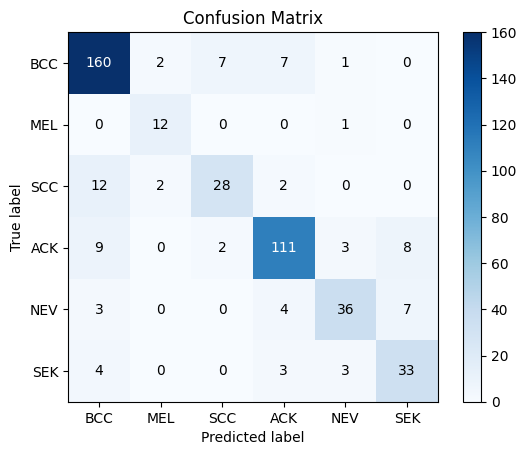

In [11]:
#Confusion matrix
class_order = ['BCC','MEL','SCC','ACK','NEV','SEK']
plot_confusion_matrix(y1_test, y1_pred, normalize=False,labels=class_order)

## SHAP

In [12]:
xgb  = pipe[-3].classifier

X_test:pd.DataFrame = pipe[:-2].transform(x1_test).drop(columns=["is_cancer"])
X_test["biopsed"] = X_test["biopsed"].apply(lambda x: 1 if x else 0)
X_train = pipe[:-2].transform(x1).drop(columns=["is_cancer"])
X_train["biopsed"] = X_train["biopsed"].apply(lambda x: 1 if x else 0)
explainer = shap.TreeExplainer(xgb,data=X_train)

During the encoding, NaN values were introduced in the feature(s) background_mother.


In [13]:
shap_values = explainer(X_train.values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


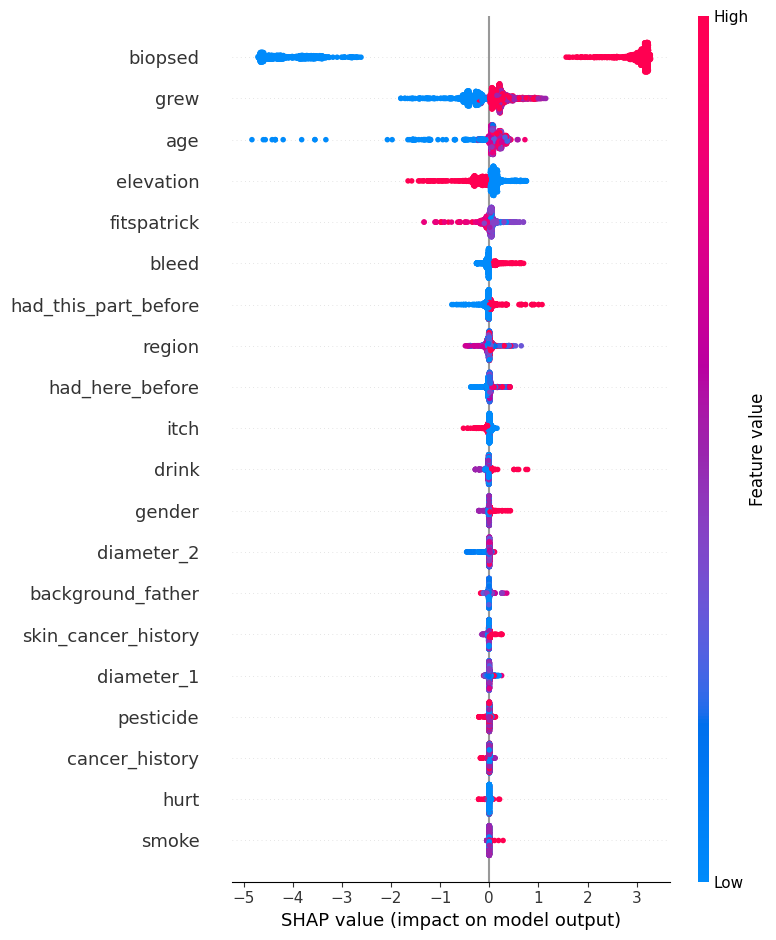

In [14]:
shap.summary_plot(shap_values, X_train)

In [15]:

def ABS_SHAP(df_shap,df):

    shap_v = pd.DataFrame(df_shap.copy())
    shap_v.columns = df.columns
    df_v = df.copy().reset_index().drop('index',axis=1)
    df_v = df_v.astype('float')
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    feature_list = df.columns
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'#ff0051','#0076f1')

    sns.set_style("whitegrid")
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False).head(10)
    k2.reset_index(inplace=True,drop=True)
    k2['SHAP_abs']=round(k2['SHAP_abs'],2)
    colorlist = k2['Sign']
    ax=sns.barplot(data=k2,y='Variable',x='SHAP_abs',palette=colorlist,)
    ax.set_xlabel("Mean SHAP Value")
    ax.legend([Line2D([0], [0], color='#ff0051', lw=4),Line2D([0], [0], color='#0076f1', lw=4)], ['Positiva', 'Negativa'],title='Correlación')


invalid value encountered in divide
invalid value encountered in divide


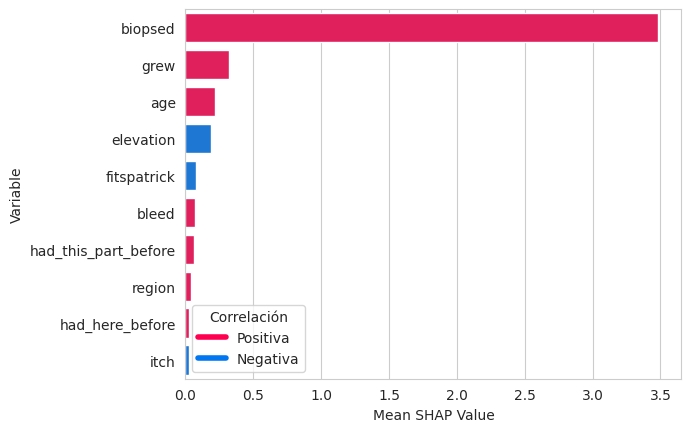

In [16]:
ABS_SHAP(shap_values.values,X_train)

In [17]:
y_pred_proba=xgb.predict_proba(X_test)[:,1]

# Get the index of the maximum probability
max_prob_index = y_pred_proba.argmax()
min_prob_index = y_pred_proba.argmin()

# Get the corresponding row in X_test
max_index_row = X_test.iloc[[max_prob_index]]
min_index_row = X_test.iloc[[min_prob_index]]

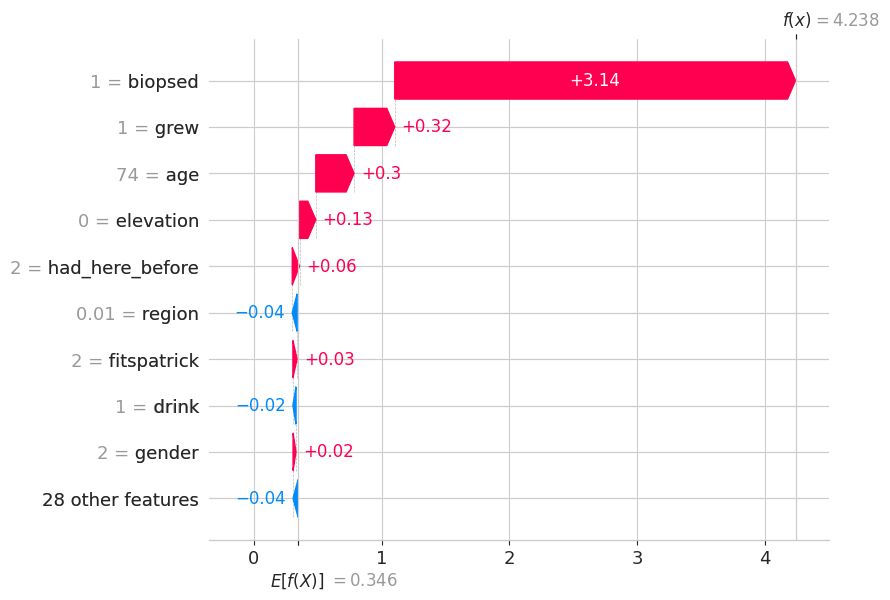

In [18]:
# Compute SHAP values
shap_values_f = explainer(max_index_row)

# Create a waterfall plot
shap.plots.waterfall(shap_values_f[0])

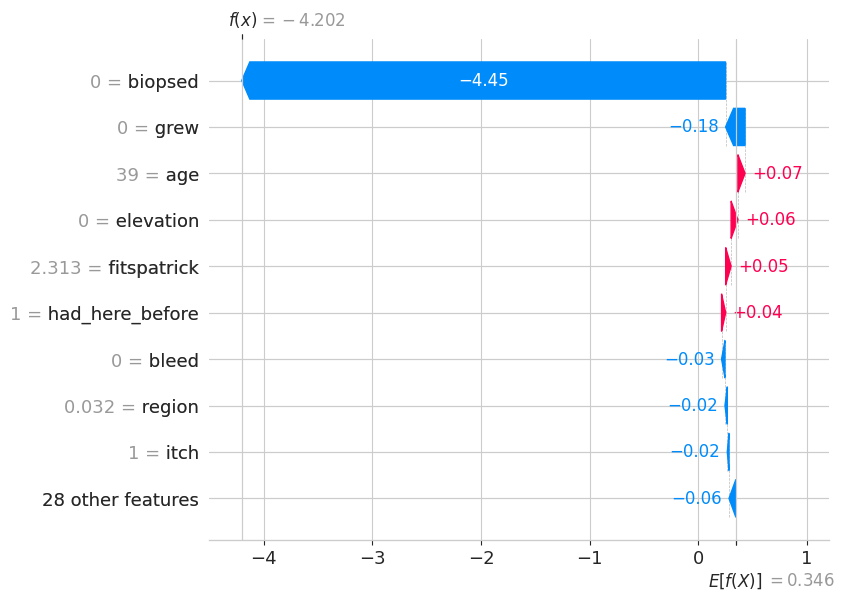

In [19]:
shap_values_f_min = explainer(min_index_row)
shap.plots.waterfall(shap_values_f_min[0])

In [20]:
shap.initjs()
shap.plots.force(shap_values_f)

In [21]:
shap.plots.force(shap_values_f_min)

## Metricas de clasificación

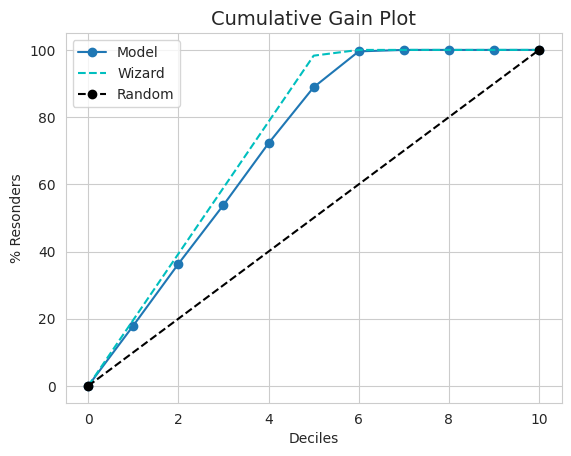

In [22]:
kds.metrics.plot_cumulative_gain(y_cancer_test, xgb.predict_proba(X_test)[:,1])

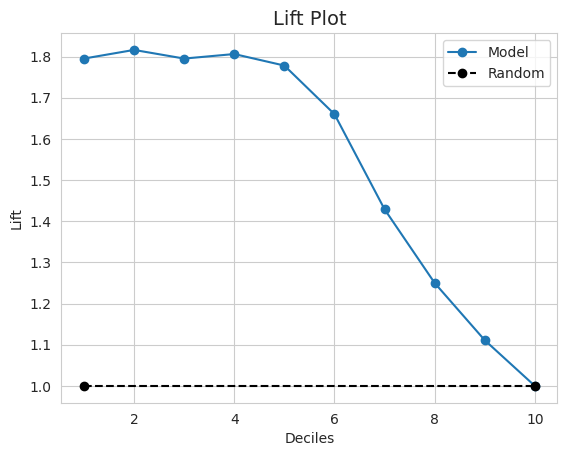

In [23]:
kds.metrics.plot_lift(y_cancer_test, xgb.predict_proba(X_test)[:,1])

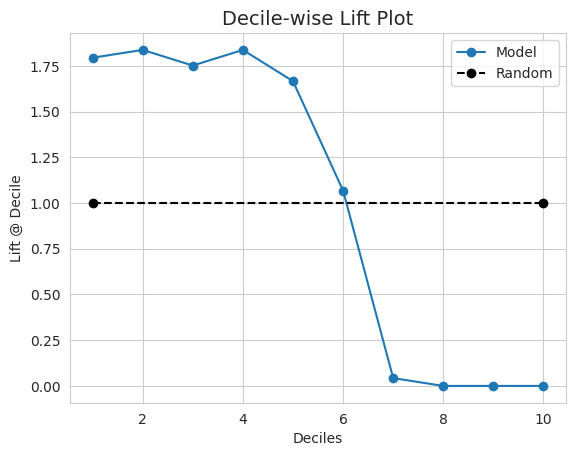

In [24]:
kds.metrics.plot_lift_decile_wise(y_cancer_test, xgb.predict_proba(X_test)[:,1])

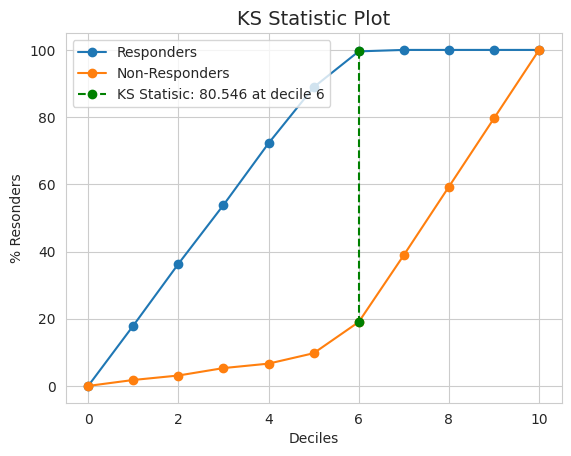

In [25]:
kds.metrics.plot_ks_statistic(y_cancer_test, xgb.predict_proba(X_test)[:,1])

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.986,0.986,0.986,46.0,42.0,4.0,23.4,46,91.304,46.0,42.0,46,4.0,10.0,17.949,19.658,1.770,16.179,1.795
1,2,0.986,0.986,0.986,46.0,43.0,3.0,23.4,46,93.478,92.0,85.0,92,7.0,20.0,36.325,39.316,3.097,33.228,1.816
2,3,0.986,0.986,0.986,46.0,41.0,5.0,23.4,46,89.130,138.0,126.0,138,12.0,30.0,53.846,58.974,5.310,48.536,1.795
3,4,0.986,0.986,0.986,46.0,43.0,3.0,23.4,46,93.478,184.0,169.0,184,15.0,40.0,72.222,78.632,6.637,65.585,1.806
4,5,0.980,0.986,0.984,46.0,39.0,7.0,23.4,46,84.783,230.0,208.0,230,22.0,50.0,88.889,98.291,9.735,79.154,1.778
5,6,0.416,0.979,0.895,46.0,25.0,21.0,23.4,4,54.348,276.0,233.0,234,43.0,60.0,99.573,100.000,19.027,80.546,1.660
6,7,0.015,0.349,0.037,46.0,1.0,45.0,23.4,0,2.174,322.0,234.0,234,88.0,70.0,100.000,100.000,38.938,61.062,1.429
7,8,0.015,0.015,0.015,46.0,0.0,46.0,23.4,0,0.000,368.0,234.0,234,134.0,80.0,100.000,100.000,59.292,40.708,1.250
8,9,0.015,0.015,0.015,46.0,0.0,46.0,23.4,0,0.000,414.0,234.0,234,180.0,90.0,100.000,100.000,79.646,20.354,1.111
9,10,0.015,0.015,0.015,46.0,0.0,46.0,23.4,0,0.000,460.0,234.0,234,226.0,100.0,100.000,100.000,100.000,0.000,1.000


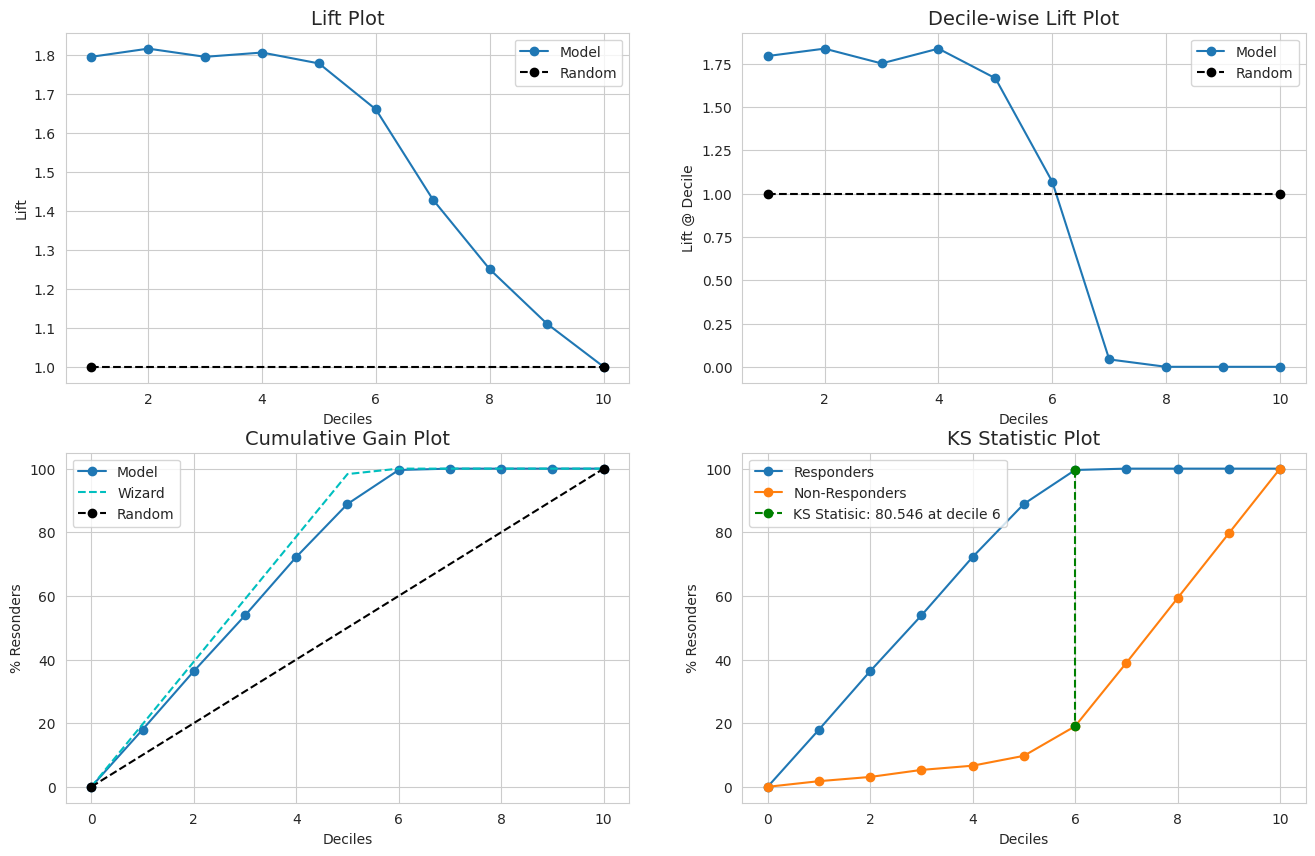

In [26]:
kds.metrics.report(y_cancer_test, xgb.predict_proba(X_test)[:,1])

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

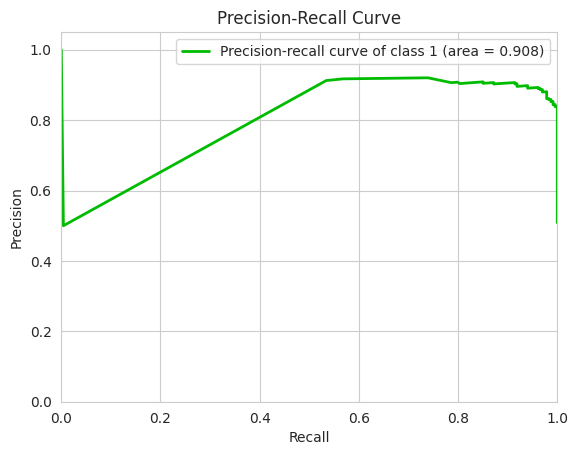

In [27]:
import numpy as np

# Reshape y_pred_proba into a 2D array if it's currently a 1D array
if y_pred_proba.ndim == 1:
    y_pred_proba = np.column_stack([1 - y_pred_proba, y_pred_proba])

# Plot the precision-recall curve
skplt.metrics.plot_precision_recall(y_cancer_test, y_pred_proba, classes_to_plot=1, plot_micro=False)

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
y_pred = y1_pred
y_test = y1_test


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ACK       0.87      0.83      0.85       133
         BCC       0.85      0.90      0.88       177
         MEL       0.75      0.92      0.83        13
         NEV       0.82      0.72      0.77        50
         SCC       0.76      0.64      0.69        44
         SEK       0.69      0.77      0.73        43

    accuracy                           0.83       460
   macro avg       0.79      0.80      0.79       460
weighted avg       0.83      0.83      0.82       460



In [30]:
#Método incluido en sklearn
from sklearn.metrics import cohen_kappa_score


accuracy=accuracy_score(y_test,y_pred)
print(f'Accuracy: {accuracy}')
print(f'Kappa Sklearn: {cohen_kappa_score(y_test, y_pred)}')
print(f'')

Accuracy: 0.8260869565217391
Kappa Sklearn: 0.7630896203639922

